[](http://)

In [1]:
import math
from typing import List, Optional, Tuple, Union
import sys
from PIL import Image
from pathlib import Path
import torch
import os
from accelerate import Accelerator
from torch import nn
from transformers import (
    AutoModel,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
    RobertaModel,
    RobertaConfig,
)
from sklearn.model_selection import train_test_split
import os
from tqdm.notebook import tqdm
import numpy as np
import torch.nn as nn
from dataclasses import dataclass
from typing import Any, Dict, Generator, List, Optional, Tuple
from torch.utils.data import Dataset, DataLoader
import pandas as pd

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings

warnings.simplefilter("ignore")
from transformers import ViTFeatureExtractor, ViTModel

2024-05-28 10:56:35.087020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 10:56:35.087114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 10:56:35.208809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


In [3]:
from einops import rearrange

In [4]:
class AttentionSelfOutput(nn.Module):
    def __init__(self, config, bias: Optional[bool] = True):
        super().__init__()
        self.dense = nn.Linear(
            config.hidden_size,
            config.hidden_size,
            bias=bias,
        )
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(
        self, hidden_states: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.layernorm(hidden_states + input_tensor)
        return hidden_states


class DecoderAttention(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.attention_bias = getattr(config, "attention_bias", True)
        self.layer_idx = layer_idx
        # self.qkv = nn.Linear(config.hidden_size,3*config.hidden_size)
        self.query = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.key = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.value = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.out = AttentionSelfOutput(config=config, bias=self.attention_bias)
        self.num_attention_heads = config.num_attention_heads

        self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention")
        if not self.flash and self.layer_idx == 0:  # avoid to print m times:
            print("WARNING: Flash Attention requires PyTorch >= 2.0")

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> Tuple[torch.Tensor, object]:
        q = self.query(hidden_state)
        k = self.key(hidden_state)
        v = self.value(hidden_state)
        # q,k,v = self.qkv(hidden_state).chunk(3, dim = -1) #b X l X d dim =-1 or 2
        # place holder for RoPe operation
        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_attention_heads)
        k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
        v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)

        if freqs is not None:
            q, k = apply_rotary_pos_emb(q, k, freqs)

        if use_cache:
            cache = getattr(self, "cache", None)
            if cache is None:
                raise ValueError(
                    "you need to setup cache for every attention layer with model.setup_cache()"
                )
            k, v = cache.update(k, v, start_pos)

        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=attention_mask
        )
        out = rearrange(out, "b h l d -> b l (h d)")

        return self.out(out, hidden_state)


class EncoderDecoderAttention(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.attention_bias = getattr(config, "attention_bias", True)
        self.layer_idx = layer_idx
        # self.qkv = nn.Linear(config.hidden_size,3*config.hidden_size)
        self.query = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.key = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.value = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.out = AttentionSelfOutput(config=config, bias=self.attention_bias)
        self.num_attention_heads = config.num_attention_heads

        self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention")
        if not self.flash and self.layer_idx == 0:  # avoid to print m times:
            print("WARNING: Flash Attention requires PyTorch >= 2.0")

    def forward(
        self,
        hidden_state: torch.Tensor,
        encoder_hidden_state: torch.Tensor,
        encoder_attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> Tuple[torch.Tensor, object]:
        q = self.query(hidden_state)
        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_attention_heads)

        if use_cache == False:  # train
            k = self.key(encoder_hidden_state)
            v = self.value(encoder_hidden_state)
            k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
            v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)
            if freqs is not None:
                q, k = apply_rotary_pos_emb(q, k, freqs=freqs)

        if use_cache == True:  # kv-cache is enable
            cache = getattr(self, "cache", None)
            if cache is None:
                raise ValueError(
                    "use_cache is True please enable model._setup_cache() to use kv-cache"
                )
            if (
                cache is not None and len(cache) == 0
            ):  # first iteration witk kv-cache so store it it will be same for rest of the iteration
                k = self.key(encoder_hidden_state)
                v = self.value(encoder_hidden_state)
                k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
                v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)
                if freqs is not None:

                    q, k = apply_rotary_pos_emb(q, k, freqs=freqs)
                k, v = self.cache.update(
                    k, v
                )  # store it will be same for all iteration

            elif cache is not None and len(cache) != 0:

                k, v = self.cache.get()  #

        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=encoder_attention_mask
        )
        out = rearrange(out, "b h l d -> b l (h d)")

        return self.out(out, hidden_state)

In [5]:
_ACT_ = {
    "gelu": nn.GELU(),
    "leaky_relu": nn.LeakyReLU(),
    "relu6": nn.ReLU6(),
    "sigmoid": nn.Sigmoid(),
    "silu": nn.SiLU(),
    "swish": nn.SiLU(),
    "tanh": nn.Tanh(),
}


class FeedForward(nn.Module):
    def __init__(self, config, multiplier: Union[int, float] = 4) -> None:
        super().__init__()
        intermediate_size = getattr(config, "intermediate_size", None)
        self.intermediate_size = (
            int(multiplier) * config.hidden_size
            if intermediate_size is None
            else intermediate_size
        )

        self.intermediate = nn.Linear(config.hidden_size, self.intermediate_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        if _ACT_.get(getattr(config, "hidden_act", None), None):
            self.act_fn = _ACT_[config.hidden_act]
        else:
            self.act_fn = nn.GELU()
        self.out = nn.Linear(self.intermediate_size, config.hidden_size)

    def forward(
        self, hidden_state: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        output = self.intermediate(hidden_state)
        output = self.act_fn(output)
        output = self.out(output)
        output = self.dropout(output)
        output = self.layernorm(output + input_tensor)
        return output

In [6]:
class AbsoluteEncoding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.pos_embeddings = nn.Embedding(
            config.max_position_embeddings,
            config.hidden_size,
            padding_idx=getattr(config, "pad_token_id", None),
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )
        self.max_size = config.max_position_embeddings

    def forward(self, size: int) -> torch.Tensor:
        if self.max_size < size:
            raise ValueError(
                f"The hidden size ({size }) is more than the config max_position_embeddings {self.max_size}"
            )
        return self.pos_embeddings(self.position_ids[:, :size])


_position_embeddings = {"absolute": AbsoluteEncoding}

In [7]:
class Seq2SeqDecoderLayer(nn.Module):
    def __init__(self, config, layer_idx: int = 0, attention_type: str = None) -> None:
        super().__init__()
        self.attention = (
            DecoderAttentionGqa(config, layer_idx=layer_idx)
            if attention_type == "gqa"
            else DecoderAttention(config, layer_idx=layer_idx)
        )
        if attention_type == "gqa" and layer_idx == 0:  # avoid to print m times
            print("Decoder Using GQA Attention")
        self.cross_attention = (
            EncoderDecoderAttentionGqa(config, layer_idx=layer_idx)
            if attention_type == "gqa" == "gqa"
            else EncoderDecoderAttention(config, layer_idx=layer_idx)
        )
        if attention_type == "gqa" and layer_idx == 0:  # avoid to print m times
            print("Using GQA in Cross Attention")
        self.feed_forward = FeedForward(config)
        self.layer_idx = layer_idx

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        encoder_hidden_state: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> torch.Tensor:
        out = self.attention(
            hidden_state=hidden_state,
            attention_mask=attention_mask,
            use_cache=use_cache,
            start_pos=start_pos,
        )
        out = self.cross_attention(
            hidden_state=out,
            encoder_hidden_state=encoder_hidden_state,
            encoder_attention_mask=encoder_attention_mask,
            use_cache=use_cache,
        )

        out = self.feed_forward(out, hidden_state)
        return out


class LMHead(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.vocab = nn.Linear(config.hidden_size, config.vocab_size)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        self.vocab.bias = self.bias

    def forward(self, hidden_state: torch.Tensor) -> torch.Tensor:
        x = self.dense(hidden_state)
        x = nn.GELU()(x)
        x = self.layer_norm(x)

        # project back to size of vocabulary with bias
        x = self.vocab(x)

        return x

In [8]:
@dataclass
class Seq2SeqOutput(object):
    logits: torch.Tensor


class LMHead(nn.Module):
    """Head for masked language modelling"""

    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.vocab = nn.Linear(config.hidden_size, config.vocab_size)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        self.vocab.bias = self.bias

    def forward(self, hidden_state: torch.Tensor) -> torch.Tensor:
        x = self.dense(hidden_state)
        x = nn.GELU()(x)
        x = self.layer_norm(x)

        # project back to size of vocabulary with bias
        x = self.vocab(x)

        return x


class Seq2SeqDecoderModel(nn.Module):
    def __init__(
        self,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> None:
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size,
            config.hidden_size,
            padding_idx=getattr(config, "pad_token_id", None),
        )
        if _position_embeddings.get(pos_embedding_type, None) is not None:
            self.position_embeddings = _position_embeddings.get(pos_embedding_type)(
                config
            )
        else:
            self.position_embeddings = None
        if pos_embedding_type == "rope":
            self.emb_freq = RotaryEmbedding(config)(config.max_position_embeddings)
            print(
                "Encoder Ignoring sinusoidal or absolute position embeddings because rope,is enable"
            )
        self.all_layer = nn.ModuleList(
            [
                Seq2SeqDecoderLayer(config, layer_idx)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=0.02 / torch.sqrt(2 * len(self.all_layer))
            )
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=0.02 / torch.sqrt(2 * len(self.all_layer))
            )

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        encoder_hidden_state: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> torch.Tensor:
        _bsz, seqlen = input_ids.shape
        hidden_state = self.word_embeddings(input_ids)
        freqs = None
        if self.position_embeddings is not None:
            pos_info = pos_info = self.position_embeddings(start_pos + seqlen)[
                :, start_pos : start_pos + seqlen, :
            ].to(input_ids.device)
            hidden_state = hidden_state + pos_info
        else:
            freqs = self.emb_freq[:, start_pos : start_pos + seqlen].to(
                input_ids.device
            )
        mask = None
        if seqlen > 1:
            mask = self.create_mask_for_decoder(
                input_ids=input_ids, attention_mask=attention_mask, start_pos=start_pos
            )
            mask = (1.0 - mask) * torch.finfo(
                hidden_state.dtype
            ).min  # invert it to to add directly to attention score

        for layer in self.all_layer:
            hidden_state = layer(
                hidden_state=hidden_state,
                attention_mask=mask,
                encoder_hidden_state=encoder_hidden_state,
                encoder_attention_mask=encoder_attention_mask,
                use_cache=use_cache,
                start_pos=start_pos,
            )
        return hidden_state

    def create_mask_for_decoder(
        self,
        input_ids,
        attention_mask: Optional[torch.Tensor] = None,
        start_pos: Optional[int] = 0,
    ) -> torch.Tensor:
        device = input_ids.device
        batch_size, seq_length = input_ids.shape
        if attention_mask is None:
            attention_mask = (
                torch.ones(seq_length + start_pos).repeat(batch_size, 1).to(device)
            )
        seq_ids = torch.arange(seq_length).to(device)
        causal_mask = (
            seq_ids[None, None, :].repeat(batch_size, seq_length, 1)
            <= seq_ids[None, :, None]
        )  # 1x1xl repeat bxlxl compare to 1xlx1

        causal_mask = causal_mask.to(attention_mask.dtype)

        if start_pos > 0:  # correct the attention mask  for kv-cache operation
            causal_mask = torch.cat(
                [
                    torch.ones(
                        (batch_size, seq_length, start_pos),
                        device=device,
                        dtype=causal_mask.dtype,
                    ),
                    causal_mask,
                ],
                axis=-1,
            )

        extended_attention_mask = (
            causal_mask[:, None, :, :] * attention_mask[:, None, None, :]
        )  # this is mainly if batch contains <PAD> tokens. stop casual procees before <PAD>
        return extended_attention_mask

    @classmethod
    def from_config(cls, config) -> nn.Module:
        return cls(config)

In [9]:
from dataclasses import dataclass
from typing import Any, Dict, Generator, List, Optional, Tuple
import torch


class DynamicCache:
    """
    A cache that grows dynamically as more tokens are generated. This is the default for generative models.

    It stores the Key and Value states as a list of tensors, one for each layer. The expected shape for each tensor is
    `[batch_size, num_heads, seq_len, head_dim]`.
    """

    def __init__(self, config) -> None:
        self.key_cache: torch.Tensor = None
        self.value_cache: torch.Tensor = None
        self._seen_tokens = False
        self.maxlen = config.max_position_embeddings

    def __len__(self) -> int:
        if self.key_cache is None:
            return 0
        """
        Support for backwards-compatible `past_key_value` length, e.g. `len(past_key_value)`. This value corresponds
        to the number of layers in the model.
        """
        return self.key_cache.shape[-2]

    def update(
        self, key_states: torch.Tensor, value_states: torch.Tensor, start_pos: int = 0
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Updates the cache with the new `key_states` and `value_states` for the layer `layer_idx`.

        Parameters:
            key_states (`torch.Tensor`):
                The new key states to cache.
            value_states (`torch.Tensor`):
                The new value states to cache.
            layer_idx (`int`):
                The index of the layer to cache the states for.
            cache_kwargs (`Dict[str, Any]`, `optional`):
                Additional arguments for the cache subclass. No additional arguments are used in `DynamicCache`.

        Return:
            A tuple containing the updated key and value states.
        """

        # Update the cache first iteration
        if self.key_cache is None:
            self._seen_tokens = True
            self.key_cache = key_states.clone()
            self.value_cache = value_states.clone()
        else:
            self.key_cache = torch.cat([self.key_cache, key_states], dim=-2)
            self.value_cache = torch.cat([self.value_cache, value_states], dim=-2)

        return self.key_cache, self.value_cache

    def get(self) -> Tuple[torch.Tensor]:
        if self._seen_tokens:
            return self.key_cache, self.value_cache
        else:
            raise ValueError("there is no token available in kv-cache")

    def get_seq_length(self, layer_idx: Optional[int] = 0) -> int:
        """Returns the sequence length of the cached states. A layer index can be optionally passed."""
        if self.key_cache is None:
            return 0
        return self.key_cache.shape[-2]

    def get_max_length(self) -> Optional[int]:
        """Returns the maximum sequence length of the cached states. DynamicCache does not have a maximum length."""
        return None


class StaticCache:
    """
    A cache that is size fixed suitable for torch.compile

    It stores the Key and Value states as a list of tensors, one for each layer. The expected shape for each tensor is
    `[batch_size, num_heads, seq_len, head_dim]`.
    """

    def __init__(self, config) -> None:
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.heads = getattr(config, "num_key_value_heads", config.num_attention_heads)
        self.key_cache: torch.Tensor = torch.zeros(
            1,
            self.heads,
            config.max_position_embeddings,
            self.head_size,
        )
        self.value_cache: torch.Tensor = torch.zeros(
            1,
            self.heads,
            config.max_position_embeddings,
            self.head_size,
        )
        self._seen_tokens = False

    def update(
        self, k: torch.Tensor, v: torch.Tensor, start_pos: int = 0
    ) -> Tuple[torch.Tensor]:
        self._seen_tokens = True
        bsz, head, seqlen, _ = k.shape
        self.first_update_len = seqlen
        if seqlen > self.key_cache.size()[2]:
            raise ValueError(
                f"{k.shape} is more than init k_cache size {self.key_cache}"
            )

        assert bsz == 1, "Only support batch size 1"

        self.key_cache = self.key_cache.to(k)
        self.value_cache = self.value_cache.to(v)

        self.key_cache[:bsz, :, start_pos : start_pos + seqlen] = k
        self.value_cache[:bsz, :, start_pos : start_pos + seqlen] = v

        k = self.key_cache[:bsz, :, : start_pos + seqlen]
        v = self.value_cache[:bsz, :, : start_pos + seqlen]

        return k, v

    def get(self) -> Tuple[torch.Tensor]:
        if self._seen_tokens:
            k = self.key_cache[:, :, : self.first_update_len]
            v = self.value_cache[:, :, : self.first_update_len]

            return k, v
        else:
            raise ValueError("there is no token available in kv-cache")

    def __len__(self) -> int:
        if self._seen_tokens == False:
            return 0
        """
        Support for backwards-compatible `past_key_value` length, e.g. `len(past_key_value)`. This value corresponds
        to the number of layers in the model.
        """
        return self.key_cache.shape[2]

In [10]:
class EncoderDecoderModel(nn.Module):

    def __init__(
        self,
        encoder,
        decoder_config,
        decoder_pos_embedding_type: Optional[str] = "absolute",
        decoder_attention_type: str = None,
    ) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = Seq2SeqDecoderModel(
            config=decoder_config,
            pos_embedding_type=decoder_pos_embedding_type,
            attention_type=decoder_attention_type,
        )
        self.lm_head = LMHead(config=decoder_config)

    def forward(
        self,
        pixel_values: Optional[torch.LongTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        encoder_output: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ):
        if encoder_output is None:
            encoder_output = self.encoder(pixel_values=pixel_values).last_hidden_state

        if encoder_attention_mask is None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_output.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            attention_mask = torch.ones(
                encoder_hidden_shape, device=encoder_output.device
            ).to(encoder_output.device)

        encoder_attention_mask = (
            attention_mask.unsqueeze(1).unsqueeze(2).type_as(encoder_output)
        )
        encoder_attention_mask = (1.0 - encoder_attention_mask) * torch.finfo(
            encoder_output.dtype
        ).min

        decoder_output = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_state=encoder_output,
            encoder_attention_mask=encoder_attention_mask,
            use_cache=use_cache,
            start_pos=start_pos,
        )
        decoder_output = self.lm_head(decoder_output)
        return Seq2SeqOutput(logits=decoder_output)

    def get_decoder(self) -> Seq2SeqDecoderModel:
        return self.decoder

    def get_encoder_output(self, pixel_values: torch.Tensor) -> object:
        return self.encoder(pixel_values=pixel_values).last_hidden_state

    def _setup_cache(self, config, cls: Optional[object] = StaticCache) -> None:
        for layer in self.decoder.all_layer:
            layer.attention.cache = cls(config)
            layer.cross_attention.cache = cls(config)

    def _clean_cache(self) -> None:
        for layer in self.decoder.all_layer:
            layer.attention.cache = None
            layer.cross_attention.cache = None

    @classmethod
    def from_config(
        cls,
        encoder,
        decoder_config,
        decoder_pos_embedding_type: Optional[str] = "absolute",
        decoder_attention_type: str = None,
    ) -> nn.Module:
        return cls(
            encoder,
            decoder_config,
            decoder_pos_embedding_type,
            decoder_attention_type,
        )

**I am using pretrained image transformer model for faster convergence**
**You can use your own image encoder model see vit tutorial**

In [11]:
vit_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config = RobertaConfig.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
seq2seq = EncoderDecoderModel(vit_encoder, config)
# roberta.encoder.layer.0.attention.self.query.weight

In [14]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`


**copy embeddings for faster convergence**

In [15]:
seq2seq.decoder.word_embeddings.weight = model.roberta.embeddings.word_embeddings.weight
seq2seq.decoder.position_embeddings.pos_embeddings.weight = (
    model.roberta.embeddings.position_embeddings.weight
)

In [16]:
del model

In [17]:
seq2seq

EncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768

In [18]:
class ImgDataset(Dataset):
    def __init__(self, df, root_dir, tokenizer, feature_extractor, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50

    def __len__(
        self,
    ):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir, image)
        img = Image.open(img_path).convert("RGB")

        #         if self.transform is not None:
        #             img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        text = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.max_length,
            add_special_tokens=False,
            truncation=True,
        )
        captions = text.input_ids
        captions = [
            caption if caption != self.tokenizer.pad_token_id else -100
            for caption in captions
        ]
        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(captions),
            "decoder_attention_mask": torch.tensor(text.attention_mask),
        }
        return encoding

In [19]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [20]:
df = pd.read_csv("../input/flickr30k/captions.txt")
df = df.dropna()
df.shape

(158914, 2)

In [21]:
# df = df.sample(frac=0.3, random_state=42)
# dff.shape
train_df, val_df = train_test_split(df, test_size=0.15)
# df.head()
train_dataset = ImgDataset(
    train_df,
    root_dir="../input/flickr30k/Images",
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
)
val_dataset = ImgDataset(
    val_df,
    root_dir="../input/flickr30k/Images",
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [22]:
def collate(input_ids):
    #     input_ids.masked_fill_(input_ids == tokenizer.pad_token_id,-100 )
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[..., 1:] = input_ids[..., :-1].clone()
    shifted_input_ids[..., 0] = tokenizer.cls_token_id

    if tokenizer.pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`

    shifted_input_ids.masked_fill_(shifted_input_ids == -100, tokenizer.pad_token_id)

    return shifted_input_ids

In [23]:
def loss_fn(prediction_scores, labels):

    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)

    lm_loss = loss_fct(prediction_scores.view(-1, config.vocab_size), labels.view(-1))
    return lm_loss

In [24]:
def validation(model, val_loader=val_loader):
    model.eval()
    all_loss = 0.0
    for step, data in tqdm(enumerate(val_loader)):
        decoder_input_ids = collate(data["labels"])
        pixel_values = data["pixel_values"].to(device)
        with torch.no_grad():
            pred = seq2seq(
                pixel_values=pixel_values,
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=data["decoder_attention_mask"].to(device),
            )
        loss = loss_fn(pred.logits, data["labels"].to(device))
        all_loss += loss.detach().cpu().item()
    print("validation_loss = ", all_loss / len(val_loader))

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def single_gpu():
    accumulation_steps = 1  # batch size 64 large dont need gradient accumulation
    lr = 5e-5
    EPOCHS = 5
    Config = {
        "num_epoch": EPOCHS,
        "learning_rate": lr,
        "loss_function": str(torch.nn.CrossEntropyLoss),
    }

    accelerator = Accelerator(
        log_with="tensorboard",
        project_dir=".",
    )
    accelerator.init_trackers("Seq2Seq_project", config=Config)
    no_decay = ["bias", "layernorm.weight", "layernorm.bias"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p
                for n, p in seq2seq.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [
                p
                for n, p in seq2seq.named_parameters()
                if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)
    num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)
    #     optimizer = torch.optim.AdamW(ptimizer_grouped_parameters, lr = lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.05 * num_train_optimization_steps,
        num_training_steps=num_train_optimization_steps,
    )

    seq2seq.to(device)

    epoch_check = len(train_loader)
    total_step = epoch_check * EPOCHS
    train_bar = tqdm(total=total_step, dynamic_ncols=True)
    t_step = 1
    k = 0
    for epoch in range(EPOCHS):
        seq2seq.train()
        avg_loss = 0.0
        loss_list = []
        running_loss = 0.0
        for step, data in enumerate(train_loader):
            train_bar.update(1)
            decoder_input_ids = collate(data["labels"])
            pixel_values = data["pixel_values"].to(device)
            optimizer.zero_grad()
            pred = seq2seq(
                pixel_values=pixel_values,
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=data["decoder_attention_mask"].to(device),
            )
            loss = loss_fn(pred.logits, data["labels"].to(device))
            loss.backward()
            optimizer.step()
            scheduler.step()

            accelerator.log({"training_loss_step": loss}, step=t_step)

            train_bar.set_description(
                f'epoch: {epoch+1} step: {t_step} loss: {"%.4f" % loss}'
            )
            t_step += 1
            loss_list.append(loss.detach().cpu().item())
        #         scheduler.step()
        avg_loss = np.round(np.mean(loss_list), 4)
        accelerator.log({"training_loss_epoch": avg_loss}, step=epoch + 1)
        print(f'Epoch: {epoch+1} loss: {"%.4f" % avg_loss }')
        validation(seq2seq)
    accelerator.end_training()
    PATH = f"vit_language_seq2seq{epoch}.pth"
    torch.save(seq2seq.state_dict(), PATH)

In [26]:
single_gpu()

  0%|          | 0/21110 [00:00<?, ?it/s]

Epoch: 1 loss: 4.0164


0it [00:00, ?it/s]

validation_loss =  3.0074397986367245
Epoch: 2 loss: 2.7301


0it [00:00, ?it/s]

validation_loss =  2.67835111490032
Epoch: 3 loss: 2.3765


0it [00:00, ?it/s]

validation_loss =  2.5445777358624757
Epoch: 4 loss: 2.1288


0it [00:00, ?it/s]

validation_loss =  2.490158461404327
Epoch: 5 loss: 1.9441


0it [00:00, ?it/s]

validation_loss =  2.478312135542799


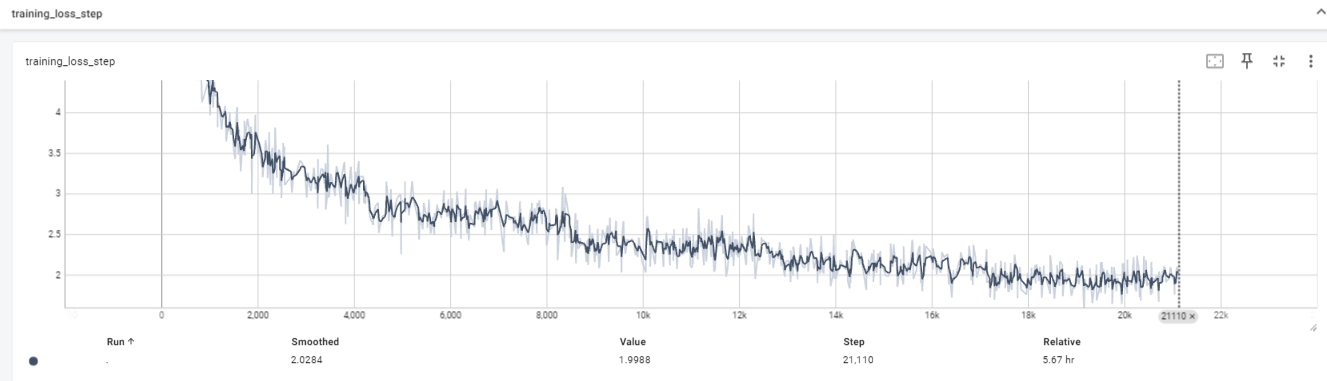

In [27]:
seq2seq.eval()

EncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768

In [28]:
import torch.nn as nn


def generate(
    model: nn.Module,
    encoder_output: torch.Tensor,
    encoder_attention_mask: torch.Tensor,
    decoder_start: torch.Tensor,
    max_new_tokens=12,
    temperature=1.0,
    do_sample=False,
    top_k=10,
    use_cache=False,
) -> torch.Tensor:
    """

    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete

    the sequence max_new_tokens times, feeding the predictions back into the model each time.

    Most likely you'll want to make sure to be in model.eval() mode of operation for this.

    """
    idx = decoder_start

    idx_next = idx

    index = 0

    #     for cur_pos in range(min_promp, total_len)

    for _ in range(max_new_tokens):

        if use_cache:
            with torch.no_grad():
                logits = model(
                    encoder_output=encoder_output,
                    decoder_input_ids=idx_next,
                    use_cache=use_cache,
                    start_pos=index,
                ).logits
            logits = logits[:, -1] / temperature
        else:
            with torch.no_grad():
                logits = model(
                    encoder_output=encoder_output,
                    decoder_input_ids=idx,
                    #                     use_cache=use_cache,
                ).logits
            if index == 0:  # start token
                logits = logits[:, -1] / temperature
            else:
                logits = logits[:, -1, :] / temperature

        probs = torch.nn.functional.softmax(logits, dim=-1)

        # either sample from the distribution or take the most likely element

        if do_sample:

            idx_next = torch.multinomial(probs, num_samples=1)

        else:

            _, idx_next = torch.topk(probs, k=1, dim=-1)

        # append sampled index to the running sequence and continue

        idx = torch.cat((idx, idx_next), dim=1)

        index = idx.size()[1] - 1  # model already have idx-1 kv-cache stored

    return idx

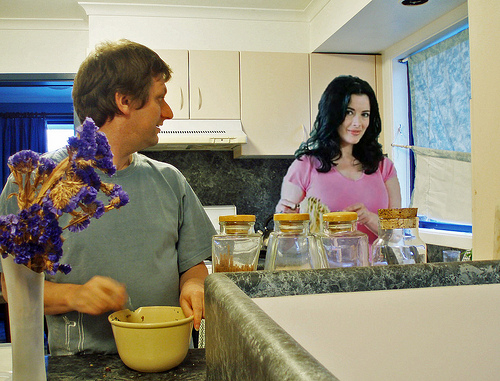

In [29]:
images = train_df["image"].values
img = Image.open(f"../input/flickr30k/Images/{images[0]}").convert("RGB")
img

In [30]:
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A man and a woman are standing in a kitchen.`'

In [31]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

In [32]:
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A man and a woman are standing in a kitchen.`'

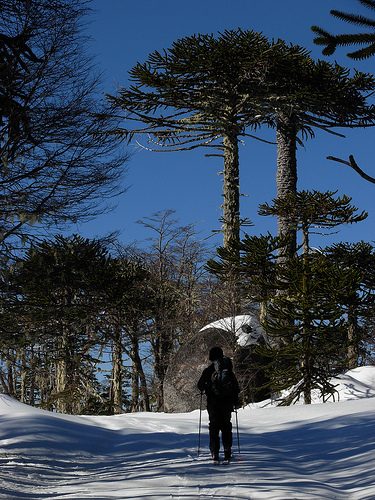

In [33]:
img = Image.open(f"../input/flickr30k/Images/{images[1]}").convert("RGB")
img

In [34]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

In [35]:
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A skier is walking through the snow.`s.'

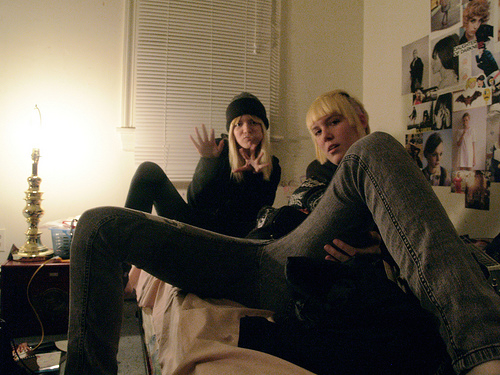

In [36]:
img = Image.open(f"../input/flickr30k/Images/{images[2]}").convert("RGB")
img

In [37]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> Two women are sitting on a bed laughing.`. "'

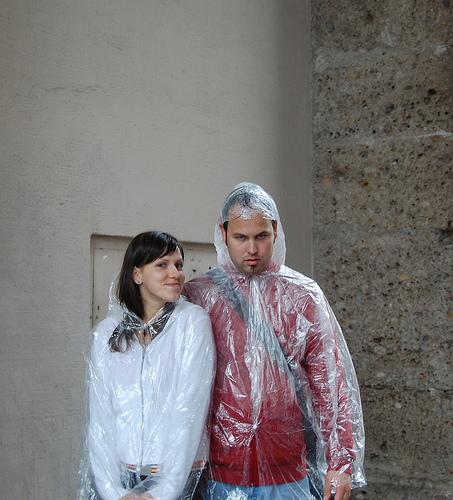

In [38]:
img = Image.open(f"../input/flickr30k/Images/{images[3]}").convert("RGB")
img

In [39]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A man and a woman in costumes are standing next to each'

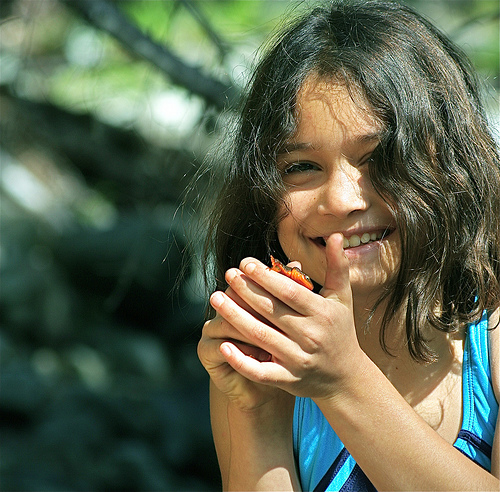

In [40]:
img = Image.open(f"../input/flickr30k/Images/{images[4]}").convert("RGB")
img

In [41]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A young girl in a blue shirt holds a large brown butterfly'

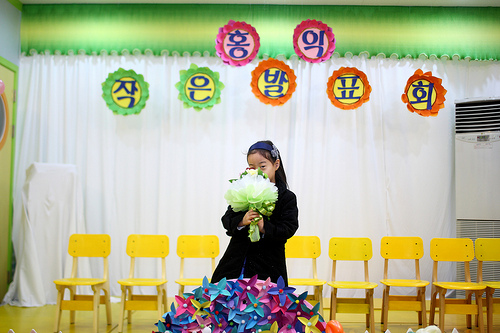

In [42]:
img = Image.open(f"../input/flickr30k/Images/{images[5]}").convert("RGB")
img

In [43]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)


pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A young girl is standing in front of a yellow table with'

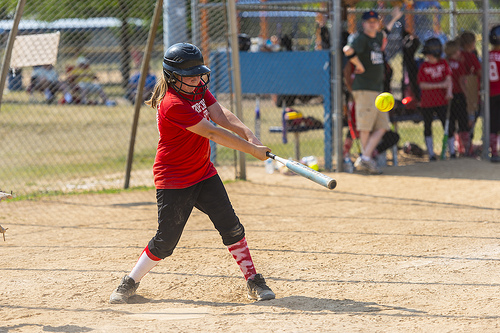

In [44]:
img = Image.open(f"../input/flickr30k/Images/{images[6]}").convert("RGB")
img

In [45]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> A girl in a red shirt and black pants is swinging at'

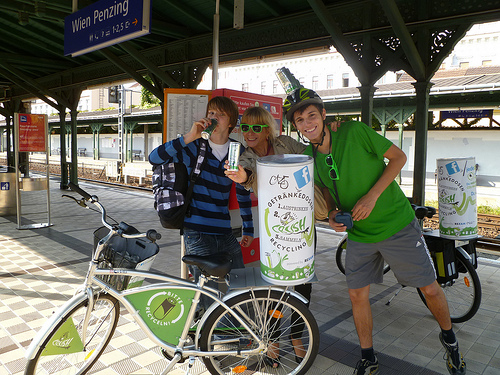

In [46]:
img = Image.open(f"../input/flickr30k/Images/{images[7]}").convert("RGB")
img

In [47]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)


pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> Three people are posing for a picture with a sign that says'

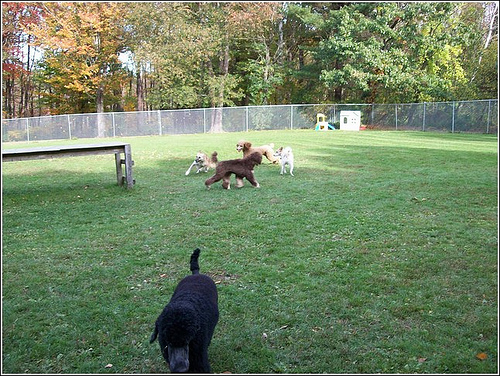

In [48]:
images = val_df["image"].values
img = Image.open(f"../input/flickr30k/Images/{images[0]}").convert("RGB")
img

In [49]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> Three dogs are playing in a yard.`s.`'

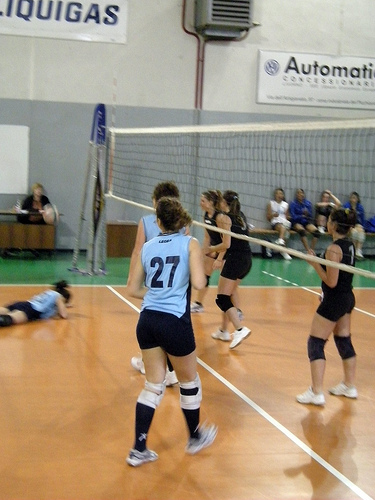

In [50]:
img = Image.open(f"../input/flickr30k/Images/{images[2]}").convert("RGB")
img

In [51]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> Girls playing volleyball. " volleyball " and " The " "'

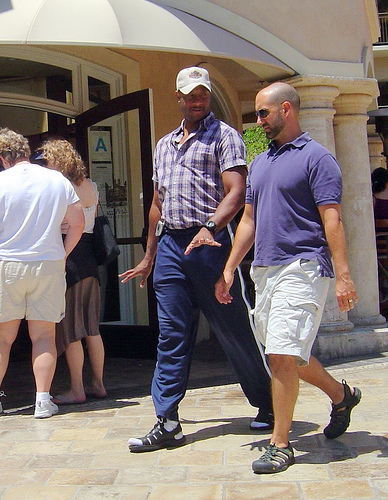

In [52]:
img = Image.open(f"../input/flickr30k/Images/{images[3]}").convert("RGB")
img

In [53]:
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> Two men in shorts and sandals walk past a group of'

In [54]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> Two men in shorts and sandals walk past a group of'

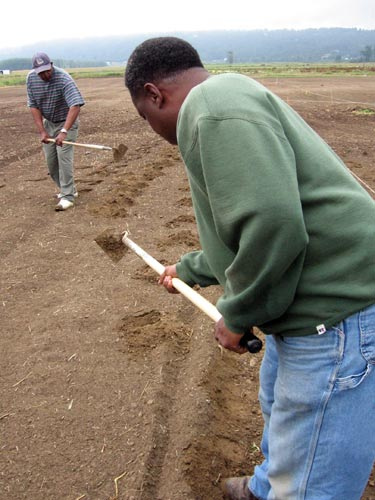

In [55]:
img = Image.open(f"../input/flickr30k/Images/{images[4]}").convert("RGB")
img

In [56]:
pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> Two men are working in a field.`s, one'

In [57]:
seq2seq._clean_cache()
seq2seq._setup_cache(config)

pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.to(device)
encoder_output = seq2seq.encoder(pixel_values=pixel_values).last_hidden_state
# encoder_output = encoder_output = seq2seq.get_encoder_output(pixel_values)
idx = torch.tensor([tokenizer.cls_token_id]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
    use_cache=True,
)
# print(all_text[3],"-->",all_summary[3])
tokenizer.decode(out[0], clean_up_tokenization_spaces=True)

'<s> Two men are working in a field.`s, one'